# Scoring normalized expression data with edgeR

----------------------

Starting with normalized RNAseq count data  the aim of this supplementary protocol is to filter and score RNAseq data using edgeR to generate the required files that can be used in most enrichment tools, but specifically GSEA and g:Profiler.  The output files of this part are the same as supplemental protocol 1 except they are generated from RNAseq data and require a different pipeline to generate. For thresholded tools like g:Profiler we need to retrieve a list of genes that are differentially expressed using a significance cut-off that will be the input of the gene-set enrichment tool. For GSEA, we need to create a file containing a ranked list of all genes. The ranked file should consist of 2 columns, the first specifies the gene name and the second a numeric value representing the level of differential expression. For both methods, the first step involves calculating a statistic for each gene that represents the degree of difference in the level of abundance between the two groups. This step is performed using the edgeR package.

## 1. Load required Bioconductor packages into R

><span style="color:purple">**TIP: we need to load the libraries each time we open a new R session, even if we have loaded an existing saved workspace.**</span>

In [1]:
library("edgeR")

Loading required package: limma


## 2. Set working directory

Make sure you set your working directory to the location of where the supplemental data 1, 2, 3 and 4 are stored.

><span style="color:purple">**TIP: the function getwd() can be used to retrieve the working directory and dir() to see what files are located in this directory**</span>

In [2]:
setwd("./data")

## 3. Load expression data 

Our dataset consists of 119 patients, 77 classified as Immunoreactive and 42 classified as Mesenchymal.RNAseq data was filtered to only include patients that also had corresponding affy expression data.

In [3]:
RNAseq <- read.table( "SupplementaryDataTable2.txt", header = TRUE, sep = "\t", quote="\"",  stringsAsFactors = FALSE ) 

><span style="color:purple">**TIP: type the command head(expressionMatrix) to see if you have loaded the matrix correctly**</span>

In [4]:
head(RNAseq) 

TCGA.13.0890.01A.01R TCGA.13.1405.01A.01R TCGA.13.1481.01A.01R
?|100130426                 0.00                 0.00                 0.00
?|100133144                60.32                75.69               155.61
?|100134869                90.68                40.31               170.39
?|10357                    27.00                64.96               112.76
?|10431                  6416.00              3686.00              3338.00
?|136542                    0.00                 0.00                 0.00
            TCGA.13.1505.01A.01R TCGA.13.1512.01A.01R TCGA.20.1682.01A.01R
?|100130426                 0.00                 0.00                 0.00
?|100133144                33.31                 6.49                18.83
?|100134869                62.69                11.51                50.17
?|10357                    79.12                58.00                40.61
?|10431                  1789.00              3871.00              1996.00
?|136542                    0.00                 0.00                 0.00
            TCGA.24.0975.01A.02R TCGA.24.1418.01A.01R TCGA.24.1427.01A.01R
?|100130426                 0.00                 0.00                  0.0
?|100133144                 3.72                24.96                110.7
?|100134869                48.28                40.04                139.3
?|10357                    37.00                96.88                125.0
?|10431                  3198.00              2370.00               3293.0
?|136542                    0.00                 0.00                  0.0
            TCGA.24.1550.01A.01R TCGA.24.1563.01A.01R TCGA.24.1564.01A.01R
?|100130426                 0.00                 0.00                 0.00
?|100133144                27.55                36.29                32.66
?|100134869               105.45                46.71                51.34
?|10357                    83.87                58.91                48.00
?|10431                  1891.00              2797.00              2502.00
?|136542                    0.00                 0.00                 0.00
            TCGA.24.2033.01A.01R TCGA.24.2035.01A.01R TCGA.24.2254.01A.01R
?|100130426                 0.00                 1.08                 0.00
?|100133144               118.28                 6.03                37.97
?|100134869               194.72                39.97                61.03
?|10357                     7.00                27.03                30.00
?|10431                   981.00               876.00               779.00
?|136542                    0.00                 0.00                 0.00
            TCGA.24.2298.01A.01R TCGA.25.1326.01A.01R TCGA.25.1328.01A.01R
?|100130426                 0.00                  0.0                 0.00
?|100133144                69.72                110.2                32.19
?|100134869               258.28                 89.8                32.81
?|10357                     9.00                 50.0                24.96
?|10431                  2810.00               2854.0               853.00
?|136542                    0.00                  0.0                 0.00
            TCGA.25.1329.01A.01R TCGA.25.1623.01A.01R TCGA.25.1633.01A.01R
?|100130426                 0.00                 0.00                 0.00
?|100133144                84.58                31.73                16.70
?|100134869                66.42                60.27                41.30
?|10357                   103.29                67.00                32.91
?|10431                  2384.00              2938.00              2823.00
?|136542                    0.00                 0.00                 0.00
            TCGA.25.1635.01A.01R TCGA.25.2399.01A.01R TCGA.25.2404.01A.01R
?|100130426                 0.00                 0.00                 0.00
?|100133144                84.88               149.94                79.95
?|100134869                57.12               229.06                65.05
?|10357                    85.74     

## 4. Load data classification

In order to calculate differential expression we need to define at least 2 classesgroups that we want to compare.  These classification will be different depending on the dataset.  A common example of classes used is Case vs Control but a genralization of the 2 class comparison can be Population 1 vs Population 2. any two classes can be compared and used to calculate differential expression.  For this analysis our dataset is divided into 2 different classes, Mmesenchymal, and Iimmunoreactive.

In [5]:
classDefinitions_RNAseq <-  read.table( "SupplementaryDataTable4.txt", header = TRUE, 
                                       sep = "\t", quote="\"",  stringsAsFactors = FALSE)

In [6]:
head(classDefinitions_RNAseq)

patient              barcode     SUBTYPE
1 TCGA-13-0890 TCGA.13.0890.01A.01R Mesenchymal
2 TCGA-13-1405 TCGA.13.1405.01A.01R Mesenchymal
3 TCGA-13-1481 TCGA.13.1481.01A.01R Mesenchymal
4 TCGA-13-1505 TCGA.13.1505.01A.01R Mesenchymal
5 TCGA-13-1512 TCGA.13.1512.01A.01R Mesenchymal
6 TCGA-20-1682 TCGA.20.1682.01A.01R Mesenchymal

## 5. Filter data

RNAseq data processing was accomplished following step 14 of edgeR [nature protocol](https://www.ncbi.nlm.nih.gov/pubmed/23975260). Filter dataset using counts per million(CPM).   Convert RNAseq data to counts per million.  Keep genes that have at least cpm > 1 for at least 42 of the samples (i.e., the minimal sample size in the classes). The aim of this step is to remove genes whose number of reads are so small that it could indicate that these genes are not expressed in the mesenchymal and immunoreactive samples and including them would add substantial noise to the data.

><span style="color:purple">**TIP: conversion to CPM is done to remove low counts but differential expression analysis will be using the normalized read counts.**</span> 

In [7]:
cpms <- cpm(RNAseq)
keep <- rowSums(cpms > 1) >= 42
counts <- RNAseq[keep,]

In [8]:
head(cpms)

TCGA.13.0890.01A.01R TCGA.13.1405.01A.01R TCGA.13.1481.01A.01R
?|100130426            0.0000000            0.0000000             0.000000
?|100133144            0.7468528            1.1628194             2.470589
?|100134869            1.1227555            0.6192793             2.705248
?|10357                0.3343008            0.9979753             1.790268
?|10431               79.4397783           56.6277220            52.996760
?|136542               0.0000000            0.0000000             0.000000
            TCGA.13.1505.01A.01R TCGA.13.1512.01A.01R TCGA.20.1682.01A.01R
?|100130426            0.0000000            0.0000000             0.000000
?|100133144            0.8307826            0.1422546             0.545385
?|100134869            1.5635472            0.2522882             1.453105
?|10357                1.9733268            1.2713043             1.176213
?|10431               44.6193335           84.8486038            57.811391
?|136542               0.0000000            0.0000000             0.000000
            TCGA.24.0975.01A.02R TCGA.24.1418.01A.01R TCGA.24.1427.01A.01R
?|100130426           0.00000000            0.0000000             0.000000
?|100133144           0.07321707            0.4930679             1.926195
?|100134869           0.95024731            0.7909630             2.423838
?|10357               0.72823427            1.9137986             2.175017
?|10431              62.94305906           46.8177407            57.298635
?|136542              0.00000000            0.0000000             0.000000
            TCGA.24.1550.01A.01R TCGA.24.1563.01A.01R TCGA.24.1564.01A.01R
?|100130426            0.0000000            0.0000000            0.0000000
?|100133144            0.3924218            0.8020468            0.6430215
?|100134869            1.5020284            1.0323396            1.0107999
?|10357                1.1946432            1.3019723            0.9450408
?|10431               26.9353792           61.8166099           49.2602517
?|136542               0.0000000            0.0000000            0.0000000
            TCGA.24.2033.01A.01R TCGA.24.2035.01A.01R TCGA.24.2254.01A.01R
?|100130426            0.0000000           0.03128685            0.0000000
?|100133144            3.2273130           0.17468492            1.1764208
?|100134869            5.3130063           1.15790322            1.8908866
?|10357                0.1909976           0.78304038            0.9294871
?|10431               26.7669431          25.37711344           24.1356813
?|136542               0.0000000           0.00000000            0.0000000
            TCGA.24.2298.01A.01R TCGA.25.1326.01A.01R TCGA.25.1328.01A.01R
?|100130426            0.0000000            0.0000000            0.0000000
?|100133144            1.1453724            2.1994063            0.9121232
?|100134869            4.2430692            1.7922566            0.9296913
?|10357                0.1478536            0.9979157            0.7072568
?|10431               46.1631732           56.9610297           24.1702733
?|136542               0.0000000            0.0000000            0.0000000
            TCGA.25.1329.01A.01R TCGA.25.1623.01A.01R TCGA.25.1633.01A.01R
?|100130426             0.000000            0.0000000            0.0000000
?|100133144             1.129384            0.6137684            0.3313419
?|100134869             0.886896            1.1658312            0.8194263
?|10357                 1.379215            1.2960128            0.6529617
?|10431                31.833184           56.8311274           56.0106622
?|136542                0.000000            0.0000000            0.0000000
            TCGA.25.1635.01A.01R TCGA.25.2399.01A.01R TCGA.25.2404.01A.01R
?|100130426             0.000000            0.0000000             0.000000
?|100133144             1.569555            2.7085064             1.316380
?|100134869             1.056232            4.1377249             1.071051
?|10357                 1.585457     

In [9]:
head(counts)

TCGA.13.0890.01A.01R TCGA.13.1405.01A.01R TCGA.13.1481.01A.01R
?|100133144                60.32                75.69               155.61
?|100134869                90.68                40.31               170.39
?|10431                  6416.00              3686.00              3338.00
?|155060                  253.00               638.00               745.00
?|57714                  1691.00              1473.00              1137.00
?|8225                   3888.00              1184.00              1250.00
            TCGA.13.1505.01A.01R TCGA.13.1512.01A.01R TCGA.20.1682.01A.01R
?|100133144                33.31                 6.49                18.83
?|100134869                62.69                11.51                50.17
?|10431                  1789.00              3871.00              1996.00
?|155060                  751.00               157.00               377.00
?|57714                   751.00              2339.00               545.00
?|8225                    564.00               796.00              1298.00
            TCGA.24.0975.01A.02R TCGA.24.1418.01A.01R TCGA.24.1427.01A.01R
?|100133144                 3.72                24.96                110.7
?|100134869                48.28                40.04                139.3
?|10431                  3198.00              2370.00               3293.0
?|155060                  108.00               620.00                441.0
?|57714                  3170.00              2351.00               2321.0
?|8225                    579.00               557.00               2025.0
            TCGA.24.1550.01A.01R TCGA.24.1563.01A.01R TCGA.24.1564.01A.01R
?|100133144                27.55                36.29                32.66
?|100134869               105.45                46.71                51.34
?|10431                  1891.00              2797.00              2502.00
?|155060                  209.00               294.00               565.00
?|57714                  1780.00              1405.00              3111.00
?|8225                   2108.00               769.00               773.00
            TCGA.24.2033.01A.01R TCGA.24.2035.01A.01R TCGA.24.2254.01A.01R
?|100133144               118.28                 6.03                37.97
?|100134869               194.72                39.97                61.03
?|10431                   981.00               876.00               779.00
?|155060                  926.00               400.00               793.00
?|57714                   449.00               737.00               706.00
?|8225                    690.00              1776.00              1595.00
            TCGA.24.2298.01A.01R TCGA.25.1326.01A.01R TCGA.25.1328.01A.01R
?|100133144                69.72                110.2                32.19
?|100134869               258.28                 89.8                32.81
?|10431                  2810.00               2854.0               853.00
?|155060                 1003.00                618.0               774.00
?|57714                  4307.00               1769.0              1269.00
?|8225                    719.00                790.0              1230.00
            TCGA.25.1329.01A.01R TCGA.25.1623.01A.01R TCGA.25.1633.01A.01R
?|100133144                84.58                31.73                 16.7
?|100134869                66.42                60.27                 41.3
?|10431                  2384.00              2938.00               2823.0
?|155060                 1061.00               860.00                251.0
?|57714                  2793.00              5217.00               2462.0
?|8225                   1033.00               877.00               1739.0
            TCGA.25.1635.01A.01R TCGA.25.2399.01A.01R TCGA.25.2404.01A.01R
?|100133144                84.88               149.94                79.95
?|100134869                57.12               229.06                65.05
?|10431                  2157.00              2097.00              2576.00
?|155060                  365.00     

## 6. Exclude unannotated genes

Exclude genes with ? or LOC as gene names  These genes are excluded as they represent genes that are not annotated and will not be present in the pathway databases  

In [10]:
exclude <- rownames(counts)[union(grep("\\?",rownames(counts)), grep("^LOC", rownames(counts)))]
counts <- counts[which(!rownames(counts) %in% exclude),]

In [11]:
head(counts)

TCGA.13.0890.01A.01R TCGA.13.1405.01A.01R TCGA.13.1481.01A.01R
A1BG|1                     649.45               853.63               638.87
A2LD1|87769                621.24               367.55               523.62
A2ML1|144568               198.00                 2.00                11.00
A2M|2                    25704.07             26276.88             11919.21
A4GALT|53947              1234.00              1618.00               675.00
AAAS|8086                 5853.00              2706.00              4047.00
             TCGA.13.1505.01A.01R TCGA.13.1512.01A.01R TCGA.20.1682.01A.01R
A1BG|1                     279.14               249.24                66.87
A2LD1|87769                 93.35               823.09               171.51
A2ML1|144568               258.00                 4.00              4857.00
A2M|2                    28849.93              8961.85             25779.70
A4GALT|53947               264.00               454.00               659.00
AAAS|8086                 3482.00              2362.00              1715.00
             TCGA.24.0975.01A.02R TCGA.24.1418.01A.01R TCGA.24.1427.01A.01R
A1BG|1                     141.00               292.87               174.29
A2LD1|87769                395.51               284.26               259.27
A2ML1|144568                44.00                76.00                71.00
A2M|2                    13424.91             11020.90             21867.95
A4GALT|53947              1974.00               708.00               663.00
AAAS|8086                 3273.00              4288.00              4119.00
             TCGA.24.1550.01A.01R TCGA.24.1563.01A.01R TCGA.24.1564.01A.01R
A1BG|1                     740.93               106.00               134.74
A2LD1|87769                173.68               267.26               188.61
A2ML1|144568               324.00                 6.00                 0.00
A2M|2                   124050.30             28039.33             26064.32
A4GALT|53947               876.00              2155.00              1559.00
AAAS|8086                 3519.00              2211.00              1910.00
             TCGA.24.2033.01A.01R TCGA.24.2035.01A.01R TCGA.24.2254.01A.01R
A1BG|1                     708.11                91.19               195.77
A2LD1|87769                205.13               229.05               146.26
A2ML1|144568                 7.00                 4.00                17.00
A2M|2                     7291.77             20800.04             15747.79
A4GALT|53947               142.00               341.00               983.00
AAAS|8086                 2466.00              1705.00              1280.00
             TCGA.24.2298.01A.01R TCGA.25.1326.01A.01R TCGA.25.1328.01A.01R
A1BG|1                     303.95               239.28               107.64
A2LD1|87769                335.64               276.87               178.85
A2ML1|144568               744.00                13.00                 1.00
A2M|2                    40423.56             21217.63             16242.75
A4GALT|53947              2542.00               792.00              1522.00
AAAS|8086                 3164.00              3486.00              1746.00
             TCGA.25.1329.01A.01R TCGA.25.1623.01A.01R TCGA.25.1633.01A.01R
A1BG|1                    1299.10               271.40               361.89
A2LD1|87769                456.68               230.81               134.99
A2ML1|144568                15.00                 4.00               214.00
A2M|2                    25166.02             17456.52             22196.07
A4GALT|53947              6465.00               839.00               422.00
AAAS|8086                 3576.00              2089.00              2724.00
             TCGA.25.1635.01A.01R TCGA.25.2399.01A.01R TCGA.25.2404.01A.01R
A1BG|1                      61.00                91.24               115.30
A2LD1|87769                244.35               187.08               369.20
A2ML1|144568                69.00                31.00       

## 7. Data exploration and normalization

Normalize data, calculate dispersions and perform differential analysis using edgeR with simple design as described in nature protocol
* Normalize the data:

In [12]:
d <- DGEList(counts=counts, group=classDefinitions_RNAseq$SUBTYPE)
d <- calcNormFactors(d)

* Examine how the two classes are divided

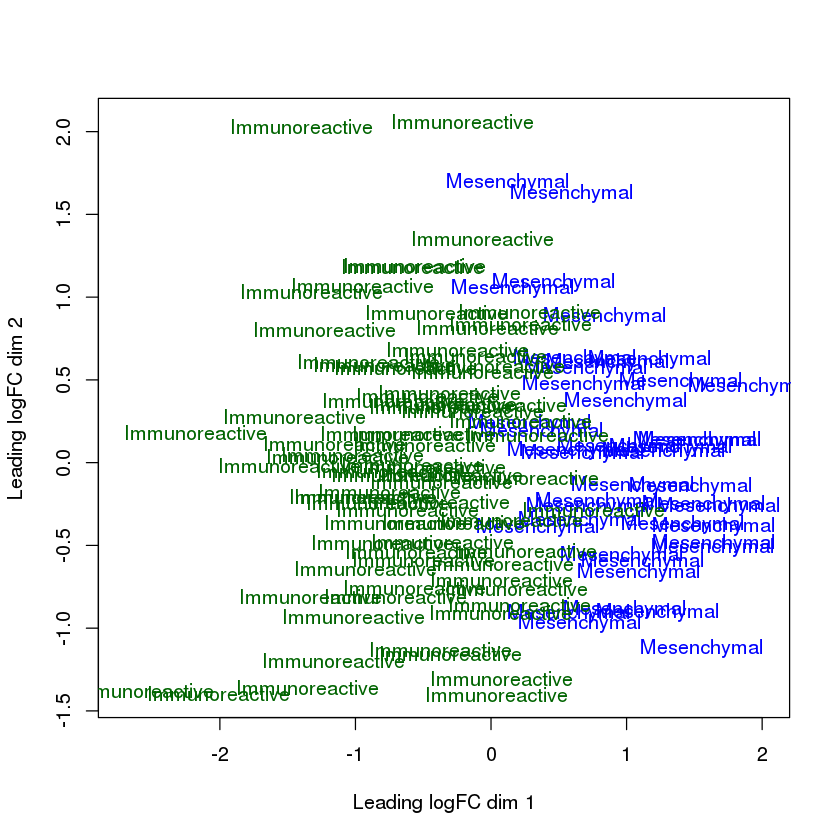

In [13]:
mds_output  <- plotMDS(d, labels=classDefinitions_RNAseq$SUBTYPE, 
                       col= c("darkgreen","blue")[factor(classDefinitions_RNAseq$SUBTYPE)])

* Estimate dispersion

In [14]:
d <- estimateCommonDisp(d)
d <- estimateTagwiseDisp(d)

In [ ]:
plotBCV(d)

In [ ]:
plotMeanVar( d ,show.raw.vars=TRUE , show.tagwise.vars=TRUE , show.binned.common.disp.vars=FALSE , 
            show.ave.raw.vars=FALSE , NBline = TRUE , nbins = 100 , pch = 16 , 
            xlab ="Mean Expression (Log10 Scale)" , ylab = "Variance (Log10 Scale)" , 
            main = "Mean-Variance Plot" )

* Calculate differential expression - Exact test

In [46]:
de <- exactTest(d, pair=c("Immunoreactive","Mesenchymal"))
tt <- topTags(de,n=nrow(d))

In [47]:
head(tt$table)

logFC   logCPM       PValue          FDR
BGN|633        1.747536 9.053804 1.727865e-33 2.496765e-29
ANTXR1|84168   1.552000 7.503491 4.394660e-31 3.175142e-27
FZD1|8321      1.284829 5.522299 4.411722e-30 2.124980e-26
COL16A1|1307   1.616403 5.093890 1.331222e-29 4.809041e-26
GPC6|10082     2.126685 3.697474 4.941914e-29 1.428213e-25
TSPAN11|441631 2.502514 1.929548 1.291615e-28 3.110639e-25

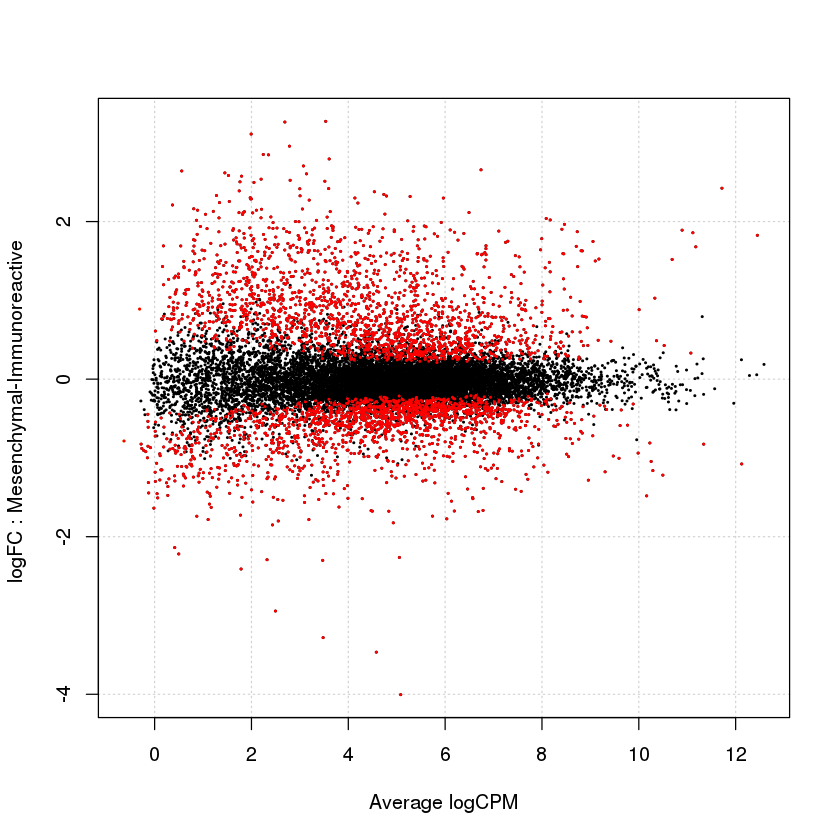

In [27]:
nc=cpm(d, normalized.lib.sizes = TRUE)
rn = rownames(tt$table)
deg =rn[tt$table$FDR<0.05]
plotSmear(d,de.tags=deg)

Number of significant genes by Exact test (FDR <0.05)

In [28]:
length(deg)

[1] 3538

## 8. Create a rank file to be used for GSEA.

In order to run PreRankedGSEA you need a two column file where each line contains a gene/protein/probe and its associated score (differential expression value).  GSEA looks for enrichment in the top and bottom part of the list.  If you use the p-value as the score, GSEA will look for enrichment in the set of most differentially expressed genes at the top of the list as well as the least differentially expressed genes at the bottom of the list. Generally, we are primarily interested at looking for enrichment in the upregulated genes (top of the list) and downregulated genes (bottom of the list).

><span style="color:purple">**TIP: A better score to use for the rank file is then the t-statistic which indicates the strength of differential expression as well as the direction.  Like many specialized analysis packages edgeR performs high level tests that model biological variability and other factors in order to calculate differential expression.  There are multiple options within edgeR to calculate differential expression (exact test, generalized linear model likelihood ratio test or the quasi-likelihood F-test).  If using the quasi-likelihood F-test then you can use the F-stat to create the rank file in the same way you can us a t-statistic.  More often than not statistical analysis performed by data centers supply p-values and foldchange over a statistic.  In the absence of such a statistic we can create a rank using the negative log(p-value) and sign of the fold change.  Genes at the top of the list are more highly expressed in class A and genes at the bottom of the list in class B. **</span>

In [29]:
ranks_RNAseq = sign(tt$table$logFC) * -log10(tt$table$PValue)
genenames <- unlist(lapply( rownames(tt$table), function(data) {unlist(strsplit(data,"\\|"))[1]}))
geneids <- unlist(lapply( rownames(tt$table), function(data) {unlist(strsplit(data,"\\|"))[2]}))

ranks_RNAseq <- cbind(genenames, ranks_RNAseq)
colnames(ranks_RNAseq) <- c("GeneName","rank")

head(ranks_RNAseq)

GeneName  rank              
[1,] "BGN"     "32.7624902258565"
[2,] "ANTXR1"  "30.3570747317634"
[3,] "FZD1"    "29.3553918174267"
[4,] "COL16A1" "28.875749397344" 
[5,] "GPC6"    "28.3061047806309"
[6,] "TSPAN11" "27.8888670133341"

In [30]:
write.table(ranks_RNAseq,"MesenchymalvsImmunoreactive_edger_ranks.rnk", col.name =TRUE, sep="\t", 
            row.names =FALSE, quote =FALSE)

## 9. Create an expression file to be used in the Enrichment Map

An expression file is similar to the expression Matrix except it has an additional column at the front in addition to the gene/protein/probe name.  This column can contain any text value and often it contains the description of the gene/protein/probe.

In [48]:
normalized_expression_RNAseq <- cpm(d, normalized.lib.size=TRUE)
genenames <- unlist(lapply( rownames(normalized_expression_RNAseq), function(data) {unlist(strsplit(data,"\\|"))[1]}))
geneids <- unlist(lapply( rownames(normalized_expression_RNAseq), function(data) {unlist(strsplit(data,"\\|"))[2]}))
EM_expressionFile_RNAseq <- cbind(genenames[which(genenames != "?")], geneids[which(genenames != "?")],
                                  normalized_expression_RNAseq[which(genenames != "?"),])
colnames(EM_expressionFile_RNAseq)[1] <- "Name"
colnames(EM_expressionFile_RNAseq)[2] <- "geneid"
colnames(EM_expressionFile_RNAseq) <- substring(colnames(EM_expressionFile_RNAseq),1,12)

write.table(EM_expressionFile_RNAseq, "MesenchymalvsImmunoreactive_RNAseq_expression.txt",col.name=TRUE,sep="\t",
            row.names=FALSE,quote=FALSE)

## 10.Create subsets of genes that can be used in g:Profiler or any thresholded enrichment tool

The subsets of genes that can be used for a thresholded method can be any set of genes.  You can uses the entire set of genes that have a significant p-value, a significant corrected p-value, up-regulated with a significant p-value, down regulated with a significant p-value or any combination of thresholds.
* To get all significant genes:

In [31]:
#get the number of significant genes
length(which(tt$table$FDR < 0.001))

[1] 1541

In [32]:
mesenvsimmuno_list <- unlist(
    lapply(rownames(tt$table[which(tt$table$FDR<0.001),]), 
           function(data) {unlist(strsplit(data,"\\|"))[1]}))
head(mesenvsimmuno_list)

[1] "BGN"     "ANTXR1"  "FZD1"    "COL16A1" "GPC6"    "TSPAN11"

In [33]:
write.table(mesenvsimmuno_list,"mesenvsimmuno_RNAseq_gprofiler.txt",
            col.name=FALSE,sep="\t",row.names=FALSE,quote=FALSE)

* To get significant genes for Immunoreactive only:

Immunoreactive genes will have negative logFC (logFC <0)

In [39]:
#get the number of significant genes - Immunoreactive
length(which(tt$table$FDR < 0.001 & tt$table$logFC < 0))

[1] 517

In [40]:
mesenvsimmuno_immuno_ordered_list <- unlist(
    lapply(rownames(tt$table[which(tt$table$FDR<0.001 & tt$table$logFC < 0),]), 
                function(data) {unlist(strsplit(data,"\\|"))[1]}))
head(mesenvsimmuno_immuno_ordered_list)

[1] "PSMB9" "TAP1"  "GBP4"  "HLA-F" "PSMB8" "IRF1"

In [41]:
write.table(mesenvsimmuno_immuno_ordered_list,
            "mesenvsimmuno_immunoonly_RNAseq_gprofiler.txt",col.name=FALSE,sep="\t",
            row.names=FALSE,quote=FALSE)

* To get significant genes for  Mesenchymal only:

Mesenchymal genes will have positive logFC (logFC >0)

In [42]:
#get the number of significant genes - Mesenchymal
length(which(tt$table$FDR < 0.001 & tt$table$logFC > 0))

[1] 1024

In [43]:
mesenvsimmuno_mesen_ordered_list <- unlist(
    lapply(rownames(tt$table[which(tt$table$FDR<0.001 & tt$table$logFC > 0),]), 
        function(data) {unlist(strsplit(data,"\\|"))[1]}))
head(mesenvsimmuno_mesen_ordered_list)

[1] "BGN"     "ANTXR1"  "FZD1"    "COL16A1" "GPC6"    "TSPAN11"

In [44]:
write.table(mesenvsimmuno_mesen_ordered_list,
            "mesenvsimmuno_mesenonly_RNAseq_gprofiler.txt",col.name=FALSE,sep="\t",
            row.names=FALSE,quote=FALSE)

## 11. Examine the results using heatmaps

Heatmaps can easily show the separation between our classes.  Limiting by the most signifincant set we can see if the scoring accurately separates class A from class B. 

In [49]:
library("pheatmap")
library("RColorBrewer")

In [51]:
#Annotate the columns with the subtype the patient belongs to.
annotation_col <- data.frame(SUBTYPE= factor(classDefinitions_RNAseq[,3]))
rownames(annotation_col) <- classDefinitions_RNAseq[,2]
ann_colors = list(
  SUBTYPE = c(Immunoreactive = "#1B9E77", Mesenchymal = "#D95F02")
)

col.pal <- rev(brewer.pal(11,"RdBu")) #create colour pallete of red and blue with 11 gradients
#filter the data to just include genes that have FDR < 0.05
matrix_for_heatmap <- as.matrix(
    EM_expressionFile_RNAseq[rownames(EM_expressionFile_RNAseq) 
            %in% rownames(tt$table)[which(tt$table$FDR<0.05)],
                    3:dim(EM_expressionFile_RNAseq)[2] ])

class(matrix_for_heatmap) <- "numeric"
matrix_for_heatmap[matrix_for_heatmap == 0] <- 0.0000001

In [ ]:
dim(matrix_for_heatmap)

In [ ]:
# use the pheatmap library to create a pretty heatmap of all significant results
# annotate the heatmap with class each sample comes from
# cluster the genes (rows) but keep the classes together. 
pheatmap(matrix_for_heatmap, color = col.pal,
         scale = "row",show_rownames = F, show_colnames = F,
         main = "heatmap top genes(Mesen vs Immuno)",
         cluster_rows = TRUE, cluster_cols = FALSE,clustering_distance_rows = "correlation",
         annotation_col=annotation_col, annotation_colors = ann_colors)

* cluster just the top 10 up (mesenchymal specific) and down (immunoreactive specific) regulated genes to get a better idea what the logFC mean

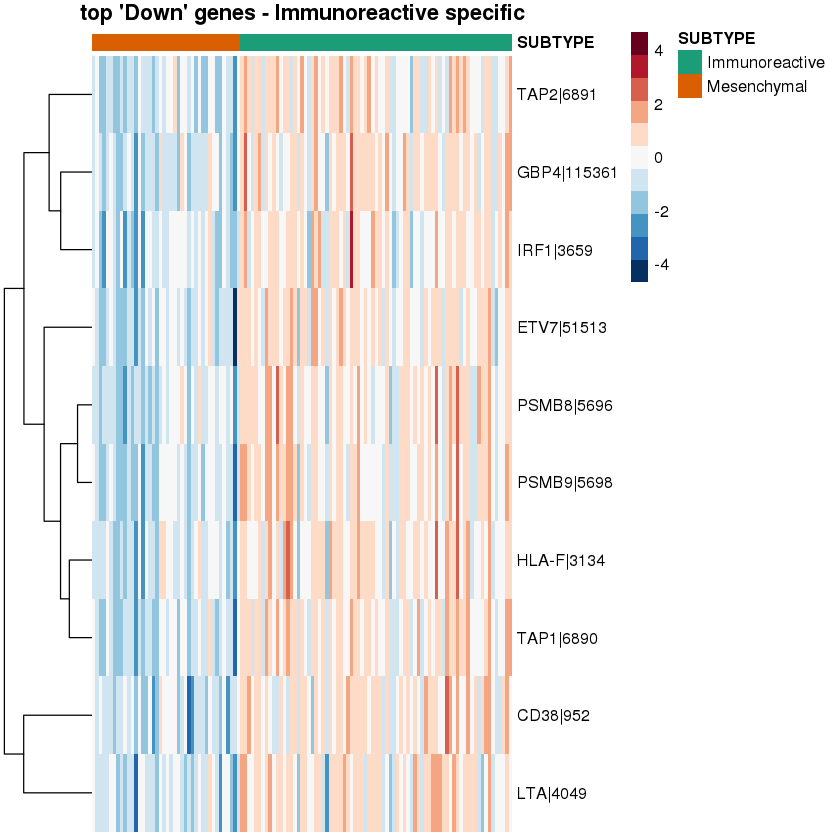

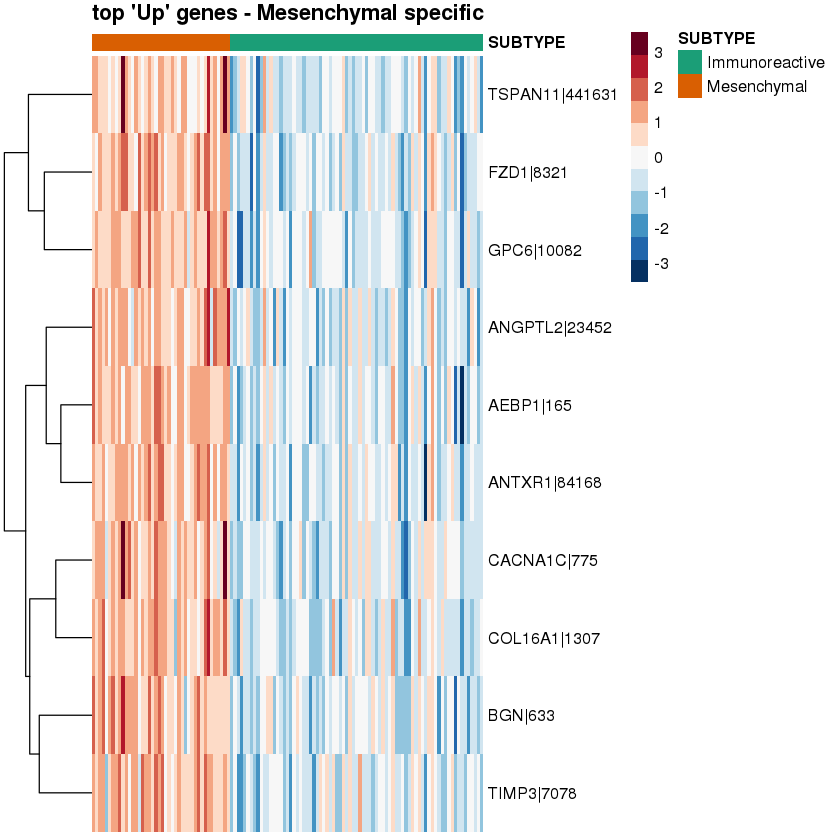

In [54]:
down <- tt$table$FDR < 0.05 & tt$table$logFC <0
up <- tt$table$FDR < 0.05 & tt$table$logFC >0

matrix_for_heatmap <- as.matrix(
    EM_expressionFile_RNAseq[rownames(EM_expressionFile_RNAseq) %in% rownames(tt$table)
                        [which(down)[1:10]],3:dim(EM_expressionFile_RNAseq)[2] ])
class(matrix_for_heatmap) <- "numeric"
matrix_for_heatmap[matrix_for_heatmap == 0] <- 0.0000001

pheatmap(log(matrix_for_heatmap), color = col.pal,
         scale = "row",show_rownames = T, show_colnames = F,
         main = "top 'Down' genes - Immunoreactive specific",
         cluster_rows = TRUE, cluster_cols = FALSE,
         clustering_distance_rows = "correlation",annotation_col=annotation_col, 
         annotation_colors = ann_colors)

matrix_for_heatmap <- as.matrix(
    EM_expressionFile_RNAseq[rownames(EM_expressionFile_RNAseq) %in% rownames(tt$table)
                        [which(up)[1:10]],3:dim(EM_expressionFile_RNAseq)[2] ])

class(matrix_for_heatmap) <- "numeric"
matrix_for_heatmap[matrix_for_heatmap == 0] <- 0.0000001

pheatmap(log(matrix_for_heatmap), color = col.pal,
         scale = "row",show_rownames = T, show_colnames = F,
         main = "top 'Up' genes - Mesenchymal specific",
         cluster_rows = TRUE, cluster_cols = FALSE,
         clustering_distance_rows = "correlation",annotation_col=annotation_col, 
         annotation_colors = ann_colors)
